In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import scanpy as sc
import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import wandb
from einops import rearrange
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
wandb.login()

wandb: Currently logged in as: estorrs (tme-st). Use `wandb login --relogin` to force relogin


True

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [46]:
from spatial_genomics_autoencoders.data.spatial_transcriptomics import (
    OverlaidHETransform, NormalizeHETransform, STDataset, MultisampleSTDataset,
    HEPredictionDataset, adata_from_visium, incorporate_hi_res)
from spatial_genomics_autoencoders.data.utils import get_means_and_stds
from spatial_genomics_autoencoders.models.metagene_autoencoder import (
    MetageneAutoencoder, LitMetageneAutoencoder, LoggingCallback)
from spatial_genomics_autoencoders.models.unet import Unet, DecoderBlock

In [6]:
train_ids = ['s0', 's3']
val_ids = ['s3']
fps = [
    '/data/estorrs/mushroom/data/test_registration/HT397B1/registered/s0.h5ad',
    '/data/estorrs/mushroom/data/test_registration/HT397B1/registered/s3.h5ad',
]
include_genes = ['EPCAM', 'KRT18', 'IL7R', 'MS4A1', 'BGN', 'SPARC', 'ACTA2']
sid_to_adata = {fp.split('/')[-1].split('.')[0]:adata_from_visium(
    fp, include_genes=include_genes, only_highly_variable=True) for fp in fps}

In [7]:
a = next(iter(sid_to_adata.values()))
a

AnnData object with n_obs × n_vars = 2984 × 4015
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'he_rescaled', 'he_rescaled_warped', 'spatial'
    obsm: 'he_rescaled_spatial', 'spatial', 'spatial_original'

In [8]:
sid_to_genes = {k:set(a.var.index.to_list()) for k, a in sid_to_adata.items()}
pool = sorted(set.intersection(*sid_to_genes.values()))
len(pool)

1745

In [9]:
sid_to_adata = {sid:a[:, pool] for sid, a in sid_to_adata.items()}

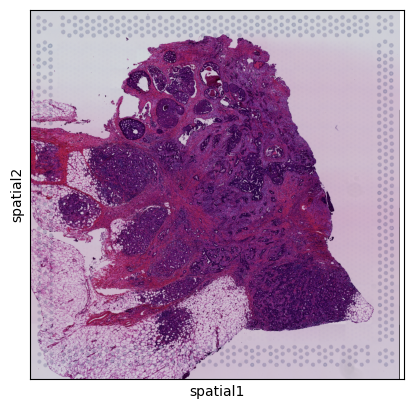

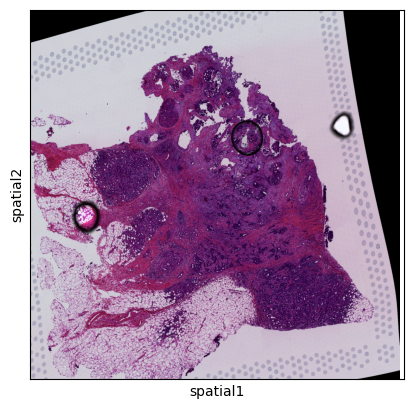

In [10]:
for sid, adata in sid_to_adata.items():
    shape = adata.uns['he_rescaled_warped'].shape
    fig, ax = plt.subplots()
    sc.pl.spatial(adata, ax=ax, crop_coord=(0, shape[0], 0, shape[1]))
    ax.set_title(sid)
    plt.show()

In [11]:
train_adatas = {sid:sid_to_adata[sid] for sid in train_ids}
val_adatas = {sid:sid_to_adata[sid] for sid in val_ids}

train_hes = {sid:a.uns['he_rescaled_warped']
            for sid, a in train_adatas.items()}
val_hes = {sid:a.uns['he_rescaled_warped']
            for sid, a in val_adatas.items()}

In [12]:
means, stds = get_means_and_stds(train_adatas.values())
means, stds

(tensor([0.5939, 0.4522, 0.5963]), tensor([0.2585, 0.3227, 0.2573]))

In [13]:
context_res = 4
size = (128, 128)
exp_size = (16, 16)
he_scale = .1

train_transform = OverlaidHETransform(
    p=.95, size=(int(size[0] * context_res), int(size[1] * context_res)),
    means=means, stds=stds)
sid_to_train_ds = {sid:STDataset(
                        a, train_hes[sid], is_fullres=True,
                        size=size, transform=train_transform, he_scale=he_scale)
                    for sid, a in train_adatas.items()}

/data/estorrs/miniconda3/envs/dino_extended/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


keys: dict_keys(['he', 'labeled_img', 'context_he', 'context_labeled_img', 'voxel_idxs', 'masks', 'exp', 'n_voxels'])


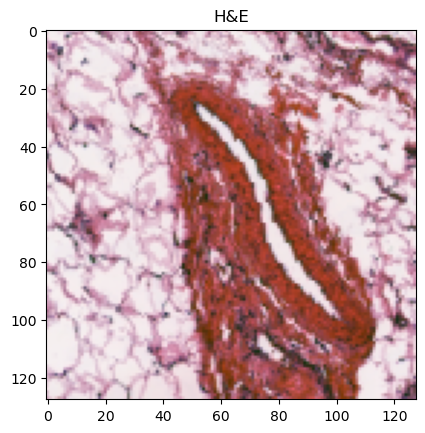

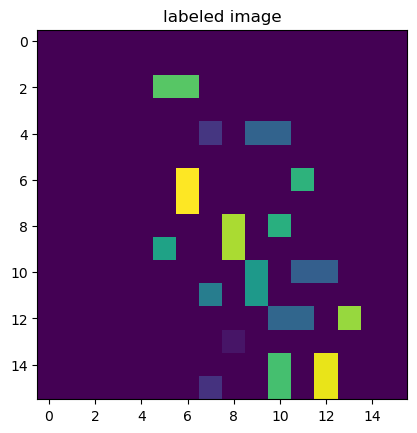

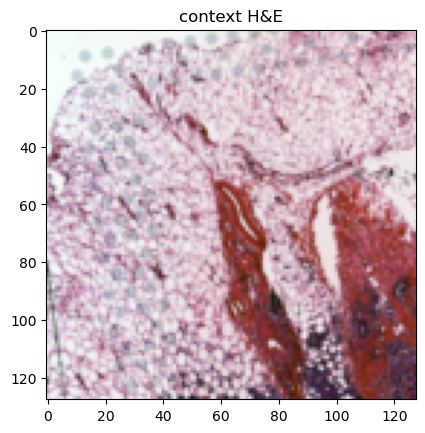

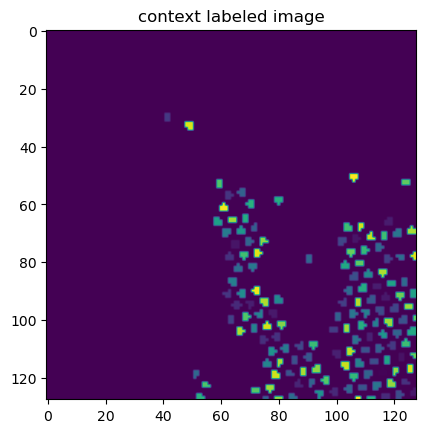

voxel idxs: tensor([ 170,  428,  461,  878,  926,  965, 1239, 1572, 1677, 1839, 1887, 2057,
        2155, 2462, 2539, 2816, 2912,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,   

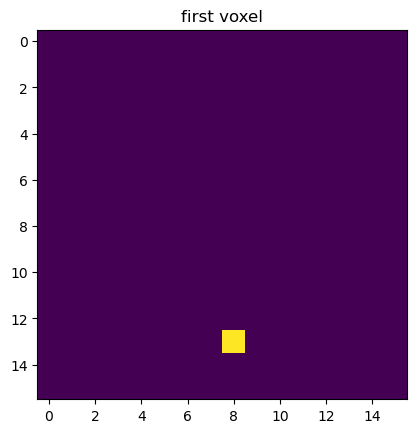

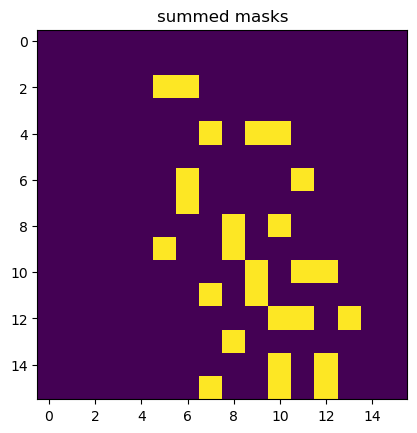

expression counts shape: torch.Size([512, 1745])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


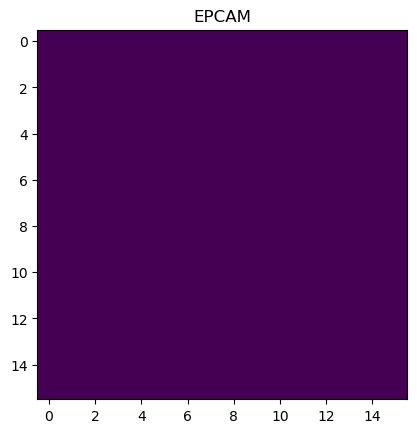

In [14]:
ds = next(iter(sid_to_train_ds.values()))
ds.sanity_check(gene='EPCAM')

In [15]:
val_transform = OverlaidHETransform(
    p=0., size=(int(size[0] * context_res), int(size[1] * context_res)),
    means=means, stds=stds)
sid_to_val_ds = {sid:STDataset(
                        a, val_hes[sid], is_fullres=True,
                        size=size, transform=val_transform, he_scale=he_scale)
                    for sid, a in val_adatas.items()}

In [16]:
train_ds = MultisampleSTDataset(sid_to_train_ds)
val_ds = MultisampleSTDataset(sid_to_val_ds)

In [17]:
for k, v in train_ds[0].items():
    print(k, v.shape)

he torch.Size([3, 128, 128])
labeled_img torch.Size([1, 16, 16])
context_he torch.Size([3, 128, 128])
context_labeled_img torch.Size([1, 128, 128])
voxel_idxs torch.Size([512])
masks torch.Size([512, 16, 16])
exp torch.Size([512, 1745])
n_voxels torch.Size([1])


In [18]:
num_workers = 40
batch_size = 32
train_dl = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dl = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False, num_workers=1)

In [19]:
# latent_dim = 64
# post_decode_he = torch.nn.Sequential( # we need to go up 3x
#     DecoderBlock(latent_dim, latent_dim, scale_factor=2.0),
#     DecoderBlock(latent_dim, latent_dim // 2, scale_factor=2.0),
#     DecoderBlock(latent_dim // 2, latent_dim // 2, scale_factor=2.0),
#     torch.nn.Conv2d(latent_dim // 2, 3, kernel_size=(1, 1))
# )

In [20]:
project = 'metagene_autoencoder_v1'
run_dir = '/data/estorrs/spatial-genomics-autoencoders/data/runs/HT397B1_v1/expression_prediction/run_1'
log_dir = os.path.join(run_dir, 'logs')
chkpt_dir = os.path.join(run_dir, 'chkpts')
Path(log_dir).mkdir(parents=True, exist_ok=True)
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [21]:
logger = WandbLogger(project=project, save_dir=log_dir)

In [22]:
# wandb.finish()

In [23]:
config = {
    'backbone': 'resnet34',
    'genes': next(iter(train_ds.ds_dict.values())).genes,
    'n_metagenes': 20,
    'latent_dim': 64,
    'he_scaler': 0.1,
    'kl_scaler': 0.001,
    'exp_scaler': 1.0,
    'decoder_channels': (256, 128),
    'size': size,
    'context_res': context_res,
    'he_scale': he_scale,
    'exp_size': exp_size,
    'means': list(means),
    'stds': list(stds),
    'training': {
        'log_n_samples': 8,
        'max_epochs': 250,
        'log_every': 1,
        'chkpt_every': 5,
        'limit_train_batches': 1.,
        'limit_val_batches': .1,
        'accelerator': 'gpu',
        'devices': [1],
        'lr': 2e-5,
        'precision': 32
    },
}
logger.experiment.config.update(config)

In [24]:
m = MetageneAutoencoder(
    config['genes'],
    n_metagenes=config['n_metagenes'],
    out_channels=config['latent_dim'],
    decoder_channels=config['decoder_channels'],
    context_decoder_channels=config['decoder_channels'],
    he_scaler=config['he_scaler'],
    kl_scaler=config['kl_scaler'],
    exp_scaler=config['exp_scaler'],
)

model = LitMetageneAutoencoder(m, config)

In [25]:
trainer = pl.Trainer(
    callbacks=[
        LoggingCallback(
            log_every=config['training']['log_every'],
            log_n_samples=config['training']['log_n_samples']
        ),
        ModelCheckpoint(
            dirpath=os.path.join(log_dir, "ckpts"),
            every_n_epochs=config['training']['chkpt_every'],
#             save_top_k=3,
#             monitor="val/overall_loss"
        )
    ],
    devices=config['training']['devices'],
    accelerator=config['training']['accelerator'],
    enable_checkpointing=True,
    max_epochs=config['training']['max_epochs'],
    precision=config['training']['precision'],
    limit_val_batches=config['training']['limit_val_batches'],
    limit_train_batches=config['training']['limit_train_batches'],
    logger=logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


In [26]:
trainer.fit(model=model, train_dataloaders=train_dl, val_dataloaders=val_dl)

/data/estorrs/miniconda3/envs/dino_extended/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /data/estorrs/spatial-genomics-autoencoders/data/runs/HT397B1_v1/expression_prediction/run_1/logs/ckpts exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type                | Params
----------------------------------------------
0 | model | MetageneAutoencoder | 48.7 M
----------------------------------------------
48.7 M    Trainable params
0         Non-trainable params
48.7 M    Total params
194.656   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/data/estorrs/miniconda3/envs/dino_extended/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [27]:
trainer

In [28]:
# trainer.save_checkpoint('/data/estorrs/spatial-genomics-autoencoders/data/runs/HT397B1_v1/expression_prediction/run_1/chkpts/ep250.pt')

In [30]:
best = LitMetageneAutoencoder.load_from_checkpoint(
    '/data/estorrs/spatial-genomics-autoencoders/data/runs/HT397B1_v1/expression_prediction/run_1/chkpts/ep250.pt')

In [117]:
best.config['context_res']

4

In [75]:
def to_uint8(x):
    x -= x.min()
    x /= x.max()
    x *= 255.
    x = x.to(torch.uint8)
    return x

class MetageneEncoder(object):
    def __init__(self, model, devices=None, accelerator=None):
        self.model = model

        if accelerator is None:
            accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
        if accelerator == 'gpu' and devices is None:
            devices = [0]

        self.encoder = pl.Trainer(
            devices=devices,
            accelerator=accelerator,
        )

    def predict(self, he, genes=None, n_workers=10, batch_size=32):
        """predict expression for H&E image"""
        # if a file then read in
        if isinstance(he, str):
            he = tifffile.imread(he)
        if he.shape[0] == 3: # dataset expects (h w c)
            he = rearrange(he, 'c h w -> h w c')

        if genes is not None:
            self.model.set_prediction_genes(genes)

        pred_transform = NormalizeHETransform(means=self.model.config['means'], stds=self.model.config['stds'])
        ds = HEPredictionDataset(
                he, size=self.model.config['size'][0], context_res=self.model.config['context_res'],
                transform=pred_transform, scale=self.model.config['he_scale'],
                exp_size=self.model.config['exp_size'][0]
        )

        dl = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=n_workers)

        result = self.encoder.predict(self.model, dataloaders=dl)

        exp = torch.concat([r['exp'] for r in result])
        exp = rearrange(exp, 'b h w c -> b c h w')
        
        # # rescale each gene
        # for i in range(exp.shape[1]):
        #     img = exp[:, 1, :, :]
        #     min_thresh = np.percentile(img, .01)
        #     max_thresh = np.percentile(img, .99)
        #     img[img < min_thresh] = min_thresh
        #     img[img > max_thresh] = max_thresh
        #     exp[:, i, :, :] = img
        exp = to_uint8(exp)
        coord_to_tile = {k:v for k, v in zip(dl.dataset.coords, exp)}
        recon_exp = dl.dataset.retile(coord_to_tile)
        

        meta = torch.concat([r['metagene_activity'] for r in result])
        meta = rearrange(meta, 'b h w c -> b c h w')
        meta = to_uint8(meta)
        coord_to_tile = {k:v for k, v in zip(dl.dataset.coords, meta)}
        recon_meta = dl.dataset.retile(coord_to_tile)


        return {
            'genes': self.model.model.genes,
            'exp': recon_exp,
            'metagene_activity': recon_meta,
            'coord_to_tile': coord_to_tile
        }


In [198]:
encoder = MetageneEncoder(best)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [199]:
prediction_genes = ['EPCAM', 'IL7R', 'ACTA2']
he = a.uns['he_rescaled_warped']

In [200]:
result = encoder.predict(he, genes=prediction_genes)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

In [201]:
result['exp'].shape, result['metagene_activity'].shape

(torch.Size([3, 196, 193]), torch.Size([20, 196, 193]))

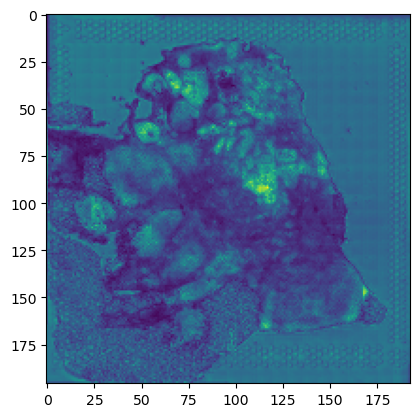

In [202]:
plt.imshow(result['exp'][0])

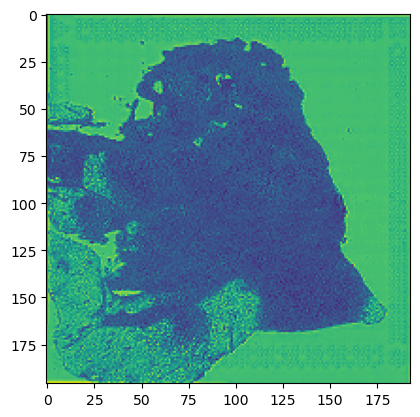

In [203]:
plt.imshow(result['metagene_activity'][0])

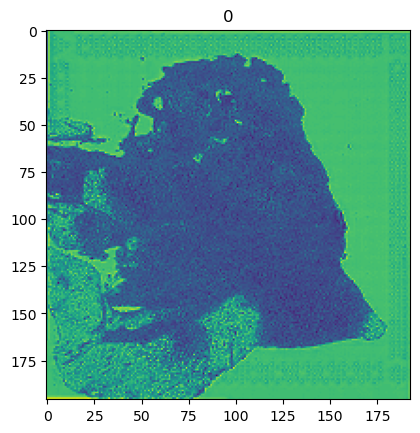

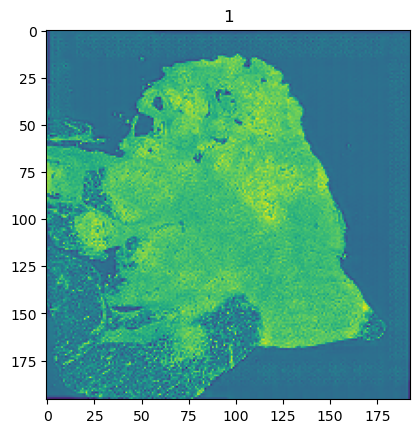

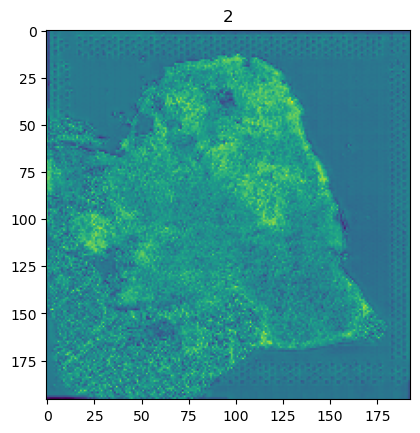

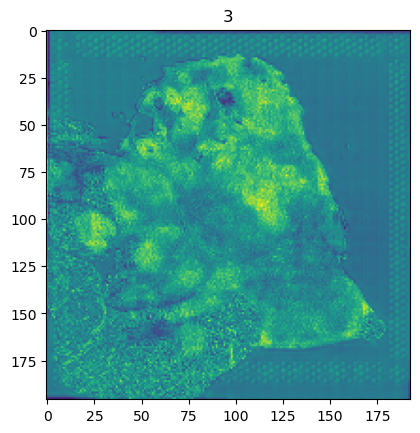

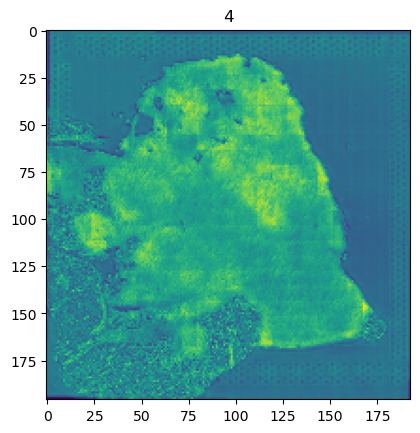

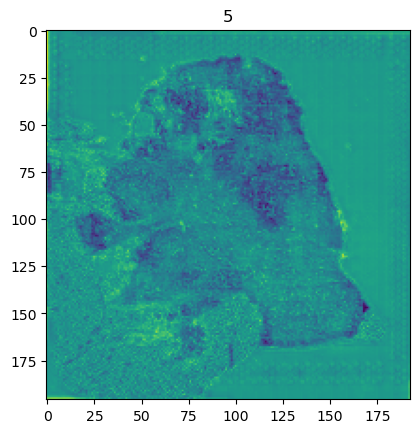

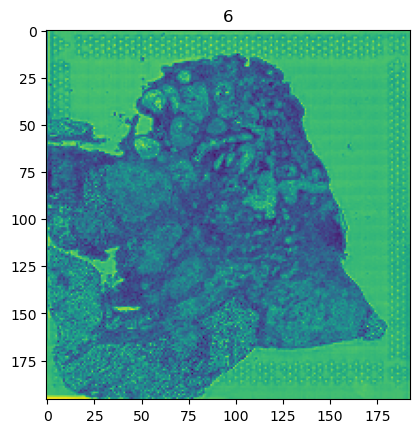

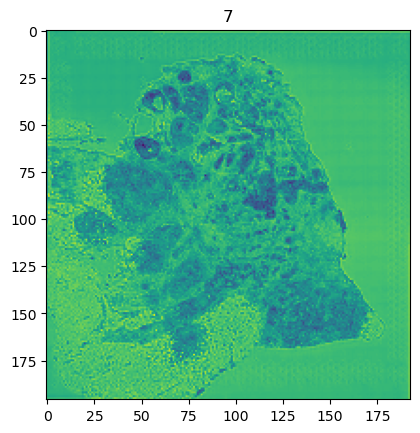

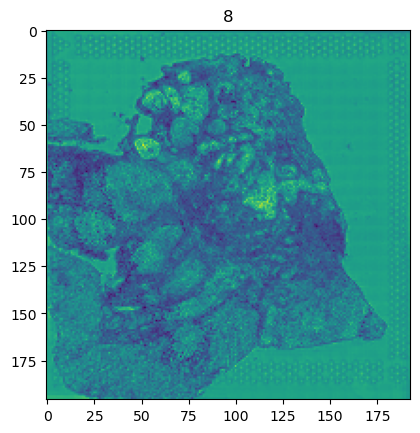

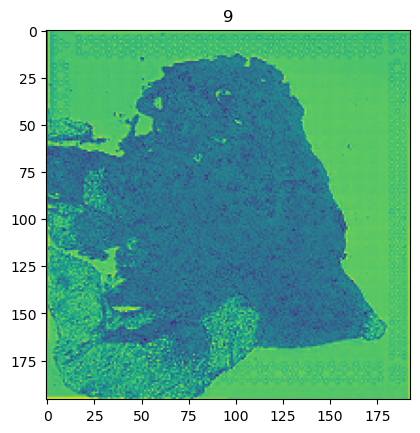

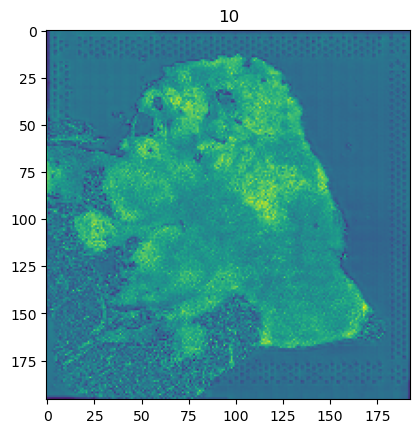

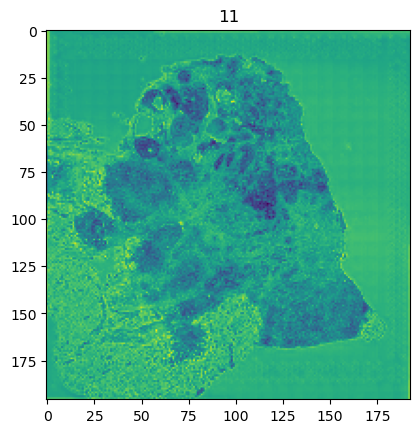

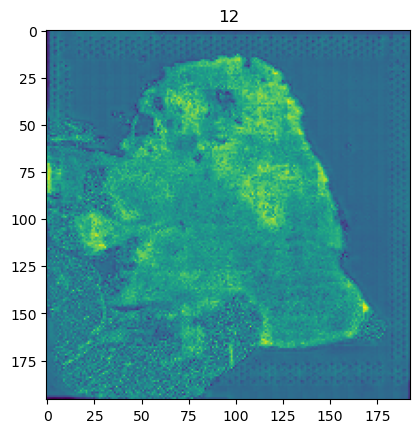

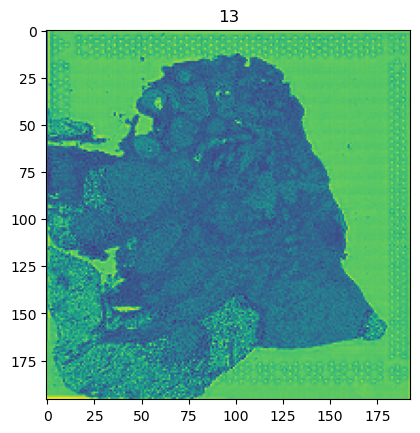

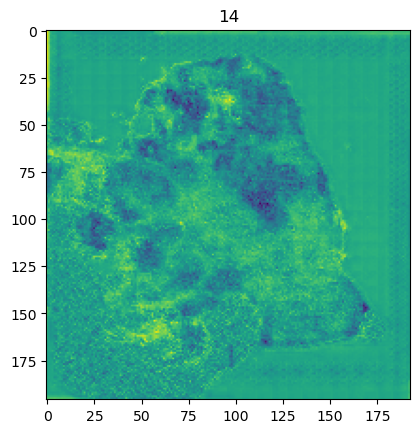

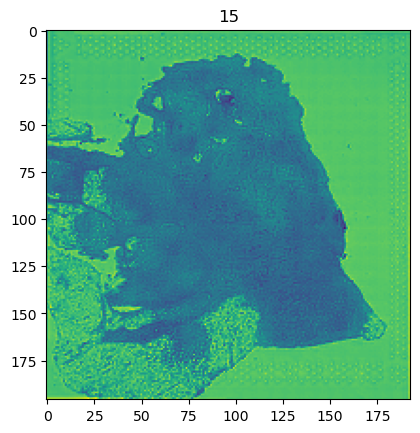

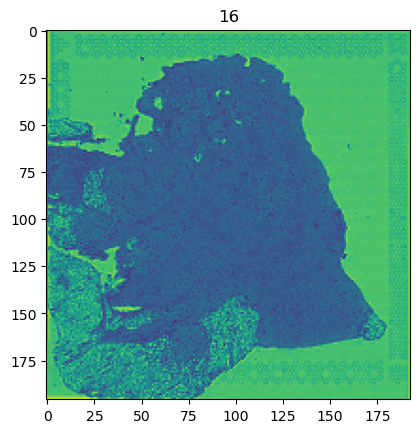

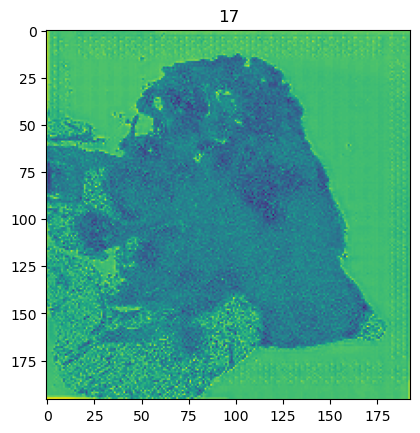

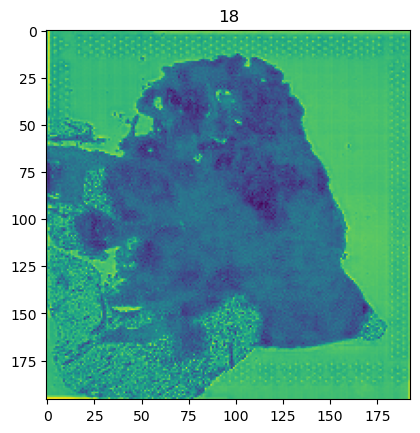

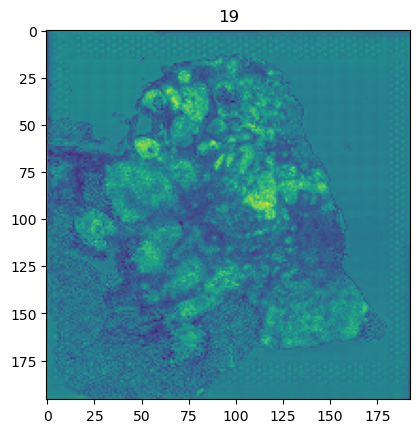

In [204]:
for i in range(result['metagene_activity'].shape[0]):
    plt.imshow(result['metagene_activity'][i])
    plt.title(i)
    plt.show()

In [206]:
out_dir = '/data/estorrs/spatial-genomics-autoencoders/data/runs/HT397B1_v1/expression_prediction/run_1/results'
Path(out_dir).mkdir(parents=True, exist_ok=True)


In [207]:
torch.save(result, os.path.join(out_dir, 'result.pt'))
